In [1]:
import util
import os
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
import matplotlib.pyplot as plt
import cv2
import random
import torch
from torchvision import models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image




In [2]:
# On va chercher les classes à prédires pour les stocker dans une liste
with open('class.names', 'r') as reader:
        classes_ = [l[:-1] for l in reader.readlines()]

#dataset_train_dict = util.get_dicts(os.path.join('data', 'train', 'imgs'), os.path.join('data', 'train', 'anns'))
#dataset_valid_dict = util.get_dicts(os.path.join('data', 'val', 'imgs'), os.path.join('data', 'val', 'anns'))

In [3]:
# On instancie le modèle de détection Detectron2 préalablement entraîné 
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/retinanet_R_101_FPN_3x.yaml'))
cfg.MODEL.WEIGHTS = './output/model_final.pth'
cfg.MODEL.DEVICE = 'cuda'

detection = DefaultPredictor(cfg)

Loading config C:\ProgramData\anaconda3\envs\test2\lib\site-packages\detectron2-0.6-py3.9-win-amd64.egg\detectron2\model_zoo\configs\COCO-Detection\../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [4]:
# On instancie le modèle de classifictaion ainsi que les transformations associées
num_classes = len(classes_)
device = 'cuda'

classifier = util.Classifier(num_classes)
classifier.to(device)
classifier.load_state_dict(torch.load('./vaid_classifier.pth'))
classifier.eval()

transformes = util.get_transform()

C:\ProgramData\anaconda3\envs\test2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\envs\test2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Fonction qui permet de visualiser les prédictions grâce aux packages Detectron2
def visualize_prediction(image, classes_):
    v = Visualizer(image, MetadataCatalog.get('train').set(thing_classes=classes_), scale=1.2)
    out = v.draw_instance_predictions(outputs_final.to('cpu'))
    plt.figure(figsize=(20,10))
    plt.axis("off")
    plt.imshow(cv2.cvtColor(out.get_image()[..., ::-1][..., ::-1], cv2.COLOR_BGR2RGB))


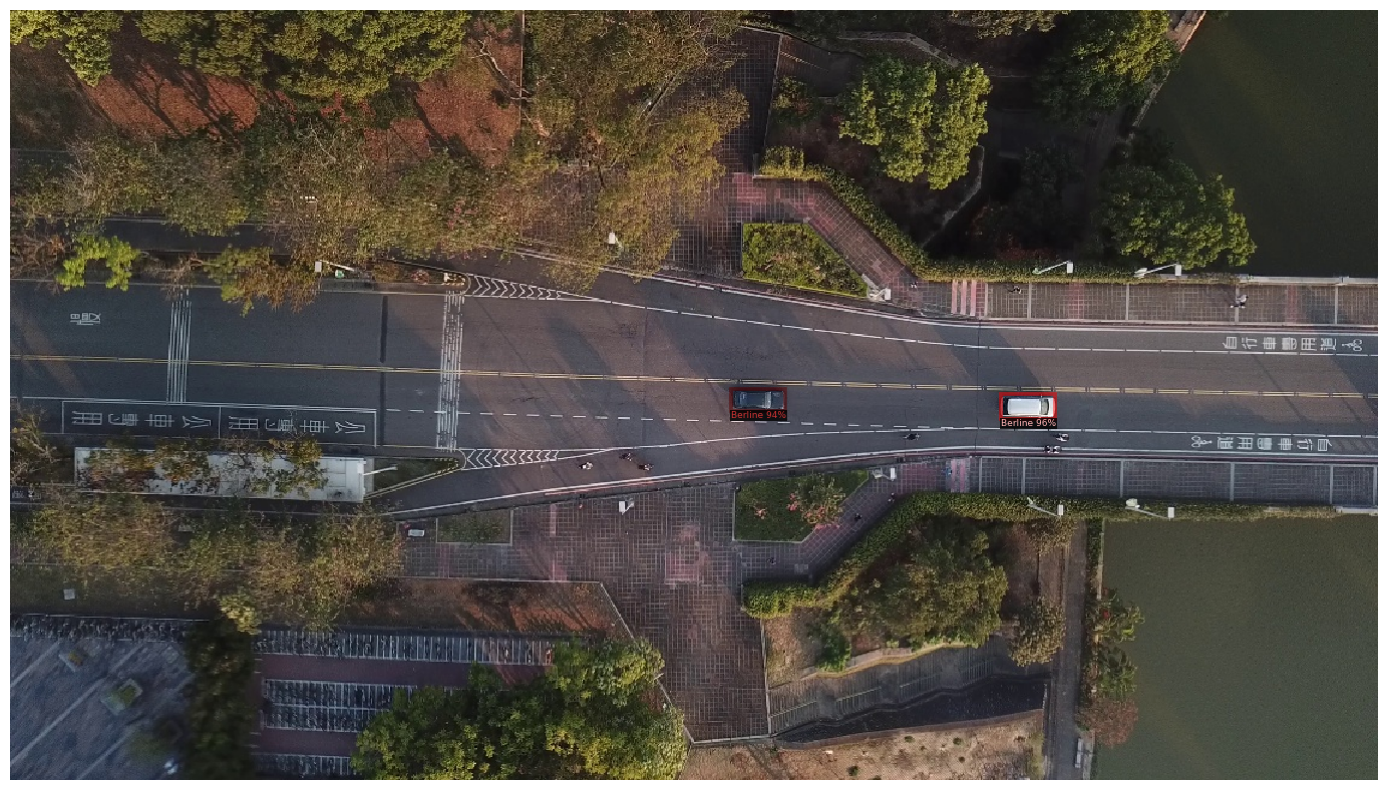

In [9]:
# On prends un image au hasard dans le dossier 'val' pour la détection
images = "./data/val/imgs/"
#images = "./imagestest/"

id = random.choice(os.listdir(images))
idimage = os.path.join(images, id)
image = cv2.imread(idimage)

# On applique les deux modèles sur l'image, le premier va détecter les véhicules, le seconds va classifier les détections
outputs_final = util.prediction(image, classifier, detection, transformes, device)

# On affiche les prédictions
visualize_prediction(image, classes_)

In [10]:
import matplotlib.pyplot as plt
import math


# Fonction qui permet d'extraire les prédictions pour les afficher séparémment dans un grid
def generate_roi_grid(roi_list, pred_classes_final, classe_name, im):
    num_images = len(roi_list)
    num_cols = int(math.ceil(math.sqrt(num_images)))
    num_rows = int(math.ceil(num_images / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i < num_images:
            roi = roi_list[i]
            x1, y1, x2, y2 = roi.tolist()
            roi = im[int(y1):int(y2), int(x1):int(x2)]
            ax.imshow(roi)
            ax.axis('off')
            ax.set_title(classe_name[pred_classes_final[i]])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.suptitle('Véhicule(s) détecté(s)') 
    plt.show()

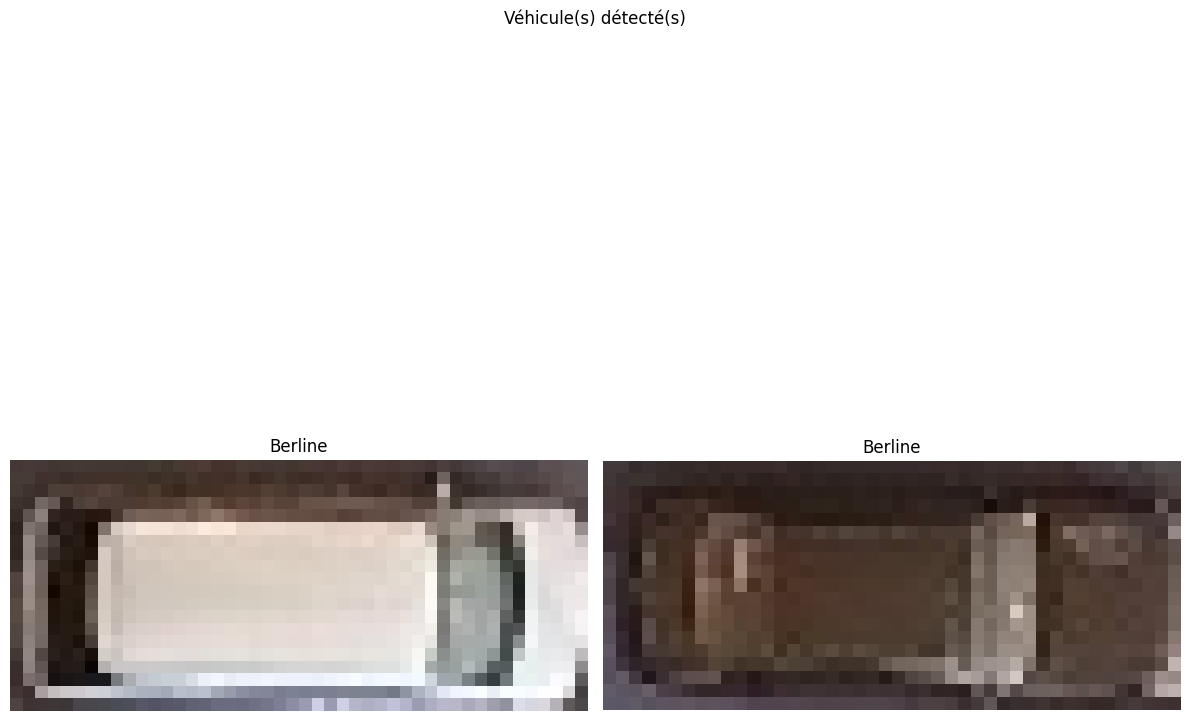

In [12]:
# On récupère les zones de prédictions et leur labels associés
rois = outputs_final.pred_boxes.tensor
pred_classes_final = outputs_final.pred_classes

# On s'affiche le tout
generate_roi_grid(rois, pred_classes_final, classes_, image)